In [1]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *
import os

%matplotlib inline

%load_ext autoreload
%autoreload 2

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
import numpy as np
from run_systematics import sys_iteration, weightmultiply, fitting_allSP, calling_sysMap

In [3]:
# calling map 
path = '/fs/scratch/PCON0003/warner785/bwarner/'
LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits') #BAO is different measurement, may be different from this analysis
# 'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits'
#GoldMask = callingEliGoldMask()
LSSMask = LSSGoldmask
GoldMask = LSSGoldmask

pixra, pixdec = hp.pix2ang(nside=512,ipix=GoldMask['PIXEL'],nest=True,lonlat=True)

LSSMask = LSSMask[pixdec >-3.0 ]
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ pixdec > -3.0 ]
GoldMask_spt = GoldMask[ pixdec < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 512, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/healpy/pixelfunc.py:526: RuntimeWarning: invalid value encountered in _pix2ang_nest
  theta, phi = pixlib._pix2ang_nest(nside, ipix)


In [4]:
sys.path.append('../../')
sys.path.append('/DMASS-analysis/measurements/code_py3/')
import esutil
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
os.chdir('../../DMASS-analysis/measurements/code_py3/')
print(os.getcwd())
from calling_catalogs import *
rootdir = '/users/PCON0003/warner785/DMASS-analysis/measurements/clustering/'
from ggl_mcal import run_ng_jk, run_nn_jk, run_nk_jk, compute_eix_jk, compute_Rgamma_jk, construct_jk, compute_jkcov, save_results

/users/PCON0003/warner785/DMASS-analysis/measurements/code_py3


In [5]:
def calling_lens_catalog(catname=None):

    catdir = ''.join([ c+'/' for c in catname.split('/')[:-1]])
    os.system('mkdir '+catdir)
    dmass = esutil.io.read(catname)
    w_dmass = dmass['CMASS_PROB']
    print ('Calculating DMASS systematic weights...')
    dmass = appendColumn(dmass, name='WEIGHT', value= w_dmass )
#   dmass = dmass[ dmass['CMASS_PROB'] > 0.01 ]   # for low probability galaxies
    esutil.io.write(catname, dmass)
    #randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')
    
    randoms = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/random_dmass_y1_public_v1.fits')
#    randoms = esutil.io.read('/users/PCON0003/warner785/DMASSY3/output/test/train_cat/y3/dmass_st82_DET200_randoms.fits')
    
#    catdir = ''.join([ c+'/' for c in catname.split('/')[:-1]])
#    os.system('mkdir '+catdir)
#    dmass = esutil.io.read('/n/des/lee.5922/data/dmass_cat/dmass_spt_sys_v3.fits')
    #w_dmass = dmass['CMASS_PROB'] *dmass['WEIGHT0_fwhm_r']*dmass['WEIGHT1_airmass_z']
    #print ('Calculatig DMASS systematic weights...')
    #dmass = appendColumn(dmass, name='WEIGHT', value= w_dmass )
    #dmass = dmass[ dmass['CMASS_PROB'] > 0.01 ]
    #esutil.io.write(catname, dmass)
    #randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')

#    randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')

    print ('Resulting catalog size')
    print ('DMASS=', np.sum(dmass['WEIGHT']) )
    print ('randoms=', randoms.size)
    return dmass, randoms

In [6]:
def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(512, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=512
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

In [7]:
def ra_dec_to_xyz(ra, dec):
    """Convert ra & dec to Euclidean points
    Parameters
    ----------
    ra, dec : ndarrays
    Returns
    x, y, z : ndarrays
    """
    sin_ra = np.sin(ra * np.pi / 180.)
    cos_ra = np.cos(ra * np.pi / 180.)

    sin_dec = np.sin(np.pi / 2 - dec * np.pi / 180.)
    cos_dec = np.cos(np.pi / 2 - dec * np.pi / 180.)

    return (cos_ra * sin_dec,
            sin_ra * sin_dec,
            cos_dec)

def uniform_sphere(RAlim, DEClim, size=1):
    """Draw a uniform sample on a sphere
    Parameters
    ----------
    RAlim : tuple
        select Right Ascension between RAlim[0] and RAlim[1]
        units are degrees
    DEClim : tuple
        select Declination between DEClim[0] and DEClim[1]
    size : int (optional)
        the size of the random arrays to return (default = 1)
    Returns
    -------
    RA, DEC : ndarray
        the random sample on the sphere within the given limits.
        arrays have shape equal to size.
    """
    zlim = np.sin(np.pi * np.asarray(DEClim) / 180.)

    z = zlim[0] + (zlim[1] - zlim[0]) * np.random.random(size)
    DEC = (180. / np.pi) * np.arcsin(z)
    RA = RAlim[0] + (RAlim[1] - RAlim[0]) * np.random.random(size)
    
    return RA, DEC

def uniform_random_on_sphere(data, size = None ):
    ra = data['RA']
    dec = data['DEC']
    
    n_features = ra.size
    #size = 100 * data.size
    
    # draw a random sample with N points
    ra_R, dec_R = uniform_sphere((min(ra), max(ra)),
                                 (min(dec), max(dec)),
                                 size)
    #data = np.asarray(ra_dec_to_xyz(ra, dec), order='F').T
    #data_R = np.asarray(ra_dec_to_xyz(ra_R, dec_R), order='F').T
    
    #random redshift distribution
    
    data_R = np.zeros((ra_R.size,), dtype=[('RA', 'float'), ('DEC', 'float')])
    data_R['RA'] = ra_R
    data_R['DEC'] = dec_R
                              
    return data_R

## ---------------------------------------------

In [8]:
#print(np.sum(int(dmass_val['WEIGHT'])))

In [9]:
# import DMASS in validation region
#lens, randoms = calling_lens_catalog('/fs/scratch/PCON0003/warner785/bwarner/dmass_y1_public_v1.fits')
dmass_val, randoms = calling_lens_catalog('/users/PCON0003/warner785/DMASSY3/output/test/train_cat/y3/dmass_st82_DET200.fits')

random_val = uniform_random_on_sphere(dmass_val, size = int(np.sum(dmass_val['WEIGHT'])))
# applying LSS mask 
random_val = keepGoodRegion(random_val)

Calculating DMASS systematic weights...
Resulting catalog size
DMASS= 28441.7573735908
randoms= 5864645


In [10]:
print(dmass_val['HPIX_4096']) 

[71771941 71771626 71773248 ... 72968986 72905874 72968681]


In [11]:
plt.rcParams.update({
  "text.usetex": False,
  "font.family": "Helvetica"
})

In [12]:
random_val = appendColumn(random_val, value=np.ones(random_val.size), name='WEIGHT')
#randomsind_val = np.random.choice( random_val.size, size=int(random_val.size/3.) )
#random_val = random_val[randomsind_val]

In [13]:
print(random_val.size)

412


In [11]:
# import DMASS in training region
#lens, randoms = calling_lens_catalog('/fs/scratch/PCON0003/warner785/bwarner/dmass_y1_public_v1.fits')
dmass_train, randoms = calling_lens_catalog('/users/PCON0003/warner785/DMASSY3/output/test/train_cat/y3/dmass_st82_DET200train.fits')

random_train = uniform_random_on_sphere(dmass_train, size = dmass_train.size)
# applying LSS mask 
random_train = keepGoodRegion(random_train)

Calculating DMASS systematic weights...
Resulting catalog size
DMASS= 20605.043776036357
randoms= 5864645


In [12]:
random_train = appendColumn(random_train, value=np.ones(random_train.size), name='WEIGHT')
randomsind_train = np.random.choice( random_train.size, size=int(random_train.size/3.) )
random_train = random_train[randomsind_train]

In [13]:
# calling CMASS

import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

print('num of train_sample after des veto', train_sample.size)

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
num of train_sample after des veto 61031


In [14]:
cmass = train_sample

rand_cmass = uniform_random_on_sphere(cmass, size = 200 * cmass.size)
rand_cmass = keepGoodRegion(rand_cmass)
rand_cmass = rand_cmass[ rand_cmass['DEC'] > -3.0 ]

In [33]:
# calling systematic maps
#sysMap = calling_sysMap( properties=properties, kind='SPT', nside=4096 )

# location of FWHM maps: /fs/scratch/PCON0003/warner785/bwarner/
# y3a2_g_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz 
# y3a2_i_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz        
# y3a2_r_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz        
# y3a2_z_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz 

# location of other maps: /fs/scratch/PCON0003/warner785/bwarner/y3/
# depending on different bands:

input_path = '/fs/scratch/PCON0003/warner785/bwarner/pca_maps_jointmask_no_stars1623/'
#y3/band_z/
input_keyword = 'pca0'
sysMap = io.SearchAndCallFits(path = input_path, keyword = input_keyword)


Calling catalogs >>>
pca0_ALL_maps_4096_ring_jointmask.fits.gz
reading 1/1 /fs/scratch/PCON0003/warner785/bwarner/pca_maps_jointmask_no_stars1623/pca0_ALL_maps_4096_ring_jointmask.fits.gz


In [ ]:
# location of 107 systematic maps now:
# /fs/scratch/PCON0003/warner785/bwarner/pca_maps_jointmask_no_stars1623/



In [ ]:
#note on using ud_grade from healpy:
#TLDR: you need to tell ud_grade which pixels are masked (where you have no data). you can use this function 
#sysHp = hp.pixelfunc.ma(sysHp, badval=0.0) 
#when you define the array of zeros to make it a masked healpy object instead of an array.

#Details:
#When you degrade a map, the new value in each pixel will be the mean of the higher resolution pixels that were 
#located within the lower resolution pixel
#You therefore have to choose what to do with the pixels where you have no data. Currently you have these set to 0. 
#This means at the edge of the footprint there will be parent pixels that are the average of some real DES data and a bunch of zeros
#Healpy has found a way around this problem by making its own type of array that tracks the mask and the data together. 
#these are constructed with hp.pixelfunc.ma as above

In [34]:
#function for healpy to reduce resolution size of sys
#make a healpix map from the sysMap:
#Healpy method: one array: index is the pixel ID, (length= number of healpix pixels in entire sphere, index = value ID, 
#signal= each value)

index_mask = np.argsort(dmass_val['HPIX_4096'])
dmass_chron = dmass_val[index_mask] # ordered by hpix values

#dim_mask = np.in1d(sysMap['PIXEL'], dmass_chron['HPIX_4096'], assume_unique=False, invert=False)

sysHp = np.zeros(hp.nside2npix(4096))
#sysHp[sysMap['PIXEL'][dim_mask]] = sysMap['SIGNAL'][dim_mask]
sysHp[sysMap['PIXEL']] = sysMap['SIGNAL']
#print(sysHp.size)
#print(sysHp[35369:35469])

#print(sysMap['PIXEL'][dim_mask][0])

nside_in = hp.pixelfunc.get_nside(sysHp)
print(nside_in)
downgrade = hp.pixelfunc.ud_grade(sysHp, 512, pess=False, order_in='RING', order_out=None, power=None, dtype=None)
nside_out = hp.pixelfunc.get_nside(downgrade)
print(nside_out)

n_good_pixels_at_512 = hp.nside2npix(nside_out)
#np.zeros(n_good_pixels_at_512, dtype=[('PIXEL','int'), ('SIGNAL','float')] )
pixels = np.zeros(n_good_pixels_at_512)
print(pixels.size)

4096
512
3145728


In [35]:
print(downgrade)

[0. 0. 0. ... 0. 0. 0.]


In [36]:
for x in range(pixels.size):
    if x>0:
        pixels[x]=pixels[x-1]+1
#print(pixels)

sysMap = np.zeros( len(pixels), dtype=[('PIXEL','int'), ('SIGNAL','float'),('RA','float'),('DEC','float')])
sysMap['PIXEL'] = pixels
sysMap['SIGNAL'] = downgrade

print(sysMap.size)
#sysMap = keepGoodRegion(sysMap)
#print(sysMap.size)

#restrict to validation region area:
theta, phi = hp.pix2ang(512, sysMap['PIXEL'])
#sys_area = np.zeros( len(phi), dtype=[('RA','float'), ('DEC','float')] )

# Convert silly ra/dec to silly HP angular coordinates.
#phi = des['RA'] * np.pi / 180.0
RA = phi*(180.0/np.pi)
DEC = -(180.0/np.pi)*theta+90.0
#theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

sysMap['RA']= RA
sysMap['DEC'] = DEC

#mask4 =(sysMap['RA']>18)&(sysMap['RA']<43)
#mask4 = mask4 & (sysMap['DEC']>-10) & (sysMap['DEC']<10)
#sysMap = sysMap[mask4]

print(sysMap.size)

#print((sysMap != 0.0 ).any())

3145728
3145728


In [37]:
print(sysMap[0:10])
print(pixels)

[(0, 0.,  45. , 89.90862927) (1, 0., 135. , 89.90862927)
 (2, 0., 225. , 89.90862927) (3, 0., 315. , 89.90862927)
 (4, 0.,  22.5, 89.81725848) (5, 0.,  67.5, 89.81725848)
 (6, 0., 112.5, 89.81725848) (7, 0., 157.5, 89.81725848)
 (8, 0., 202.5, 89.81725848) (9, 0., 247.5, 89.81725848)]
[0.000000e+00 1.000000e+00 2.000000e+00 ... 3.145725e+06 3.145726e+06
 3.145727e+06]


In [38]:
#all griz combined fracdet map

path = '/fs/scratch/PCON0003/warner785/bwarner/'
fracDet = fitsio.read(path+'y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz')

print(fracDet.dtype.names)
print(fracDet['SIGNAL'])

('PIXEL', 'SIGNAL')
[1.      0.875   1.      ... 0.09375 0.8125  0.0625 ]


In [39]:
print(LSSGoldmask["SIGNAL"])

[1.     1.     1.     ... 1.     1.     0.9375]


In [40]:
#dim_mask = np.in1d(sysMap['PIXEL'], dmass_chron['HPIX_4096'], assume_unique=False, invert=False)

#print(dmass_chron['HPIX_4096'])

from numpy.lib.recfunctions import append_fields

theta, phi = hp.pix2ang(4096, dmass_chron['HPIX_4096'])
HPIX_512 = hp.ang2pix(512, theta, phi)

dmass_chron = append_fields(dmass_chron, 'HPIX_512', HPIX_512, usemask=False)
print(dmass_chron.dtype.names)

# hp.-- conversion -- use RA DEC, or Su's code -- github -- add column of HPIX_512
# pixel ID of nside --> pixel ID of new nside
# or existing column added

('COADD_OBJECT_ID', 'RA', 'DEC', 'HPIX_4096', 'MAG_DETMODEL_G', 'MAGERR_DETMODEL_G', 'MAG_DETMODEL_R', 'MAGERR_DETMODEL_R', 'MAG_DETMODEL_I', 'MAGERR_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_Z', 'MOF_CM_MAG_ERR_G', 'MOF_CM_MAG_ERR_R', 'MOF_CM_MAG_ERR_I', 'MOF_CM_MAG_ERR_Z', 'MOF_CM_MAG_CORRECTED_G', 'MOF_CM_MAG_CORRECTED_R', 'MOF_CM_MAG_CORRECTED_I', 'MOF_CM_MAG_CORRECTED_Z', 'SOF_CM_MAG_ERR_G', 'SOF_CM_MAG_ERR_R', 'SOF_CM_MAG_ERR_I', 'SOF_CM_MAG_ERR_Z', 'SOF_CM_MAG_CORRECTED_G', 'SOF_CM_MAG_CORRECTED_R', 'SOF_CM_MAG_CORRECTED_I', 'SOF_CM_MAG_CORRECTED_Z', 'EXTENDED_CLASS_MASH_SOF', 'CMASS_PROB', 'WEIGHT', 'HPIX_512')


In [31]:
print(dmass_chron['HPIX_512'])
print(dmass_chron['HPIX_4096'])

[    511     511     521 ... 2359127 2359127 2359127]
[    35370     35370     35456 ... 150977212 150977212 150977214]


[0. 0. 0. ... 0. 0. 0.]
[   40.36543508    29.46389429    40.24832517    49.05555949
    47.41813533    32.33945637    46.56472312    43.57439358
 27668.94441939    30.39139238    29.84485674    39.74459025]


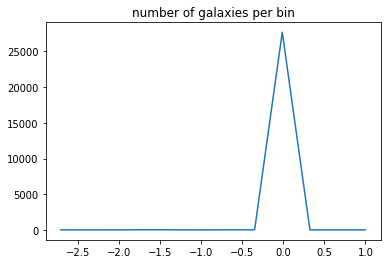

In [41]:
#Jack's method:
import matplotlib.pyplot as plt

#np.percentile()

dim_mask = np.in1d(sysMap['PIXEL'], dmass_chron['HPIX_512'], assume_unique=False, invert=False)

minimum = np.percentile(sysMap['SIGNAL'][dim_mask], 1)
#minimum = np.percentile(sysMap['SIGNAL'], 1)
#minimum = np.min(sysMap['SIGNAL'][dim_mask]) #FWHM signal (for g filter)
maximum = np.percentile(sysMap['SIGNAL'][dim_mask], 99)
#maximum = np.percentile(sysMap['SIGNAL'], 99)
#maximum = np.max(sysMap['SIGNAL'][dim_mask])
#print(minimum)
#print(maximum)

pbin = np.linspace(minimum, maximum, 13)
pcenter = pbin[:-1] + 0.025

x = np.zeros(hp.nside2npix(512))
x[sysMap['PIXEL'][dim_mask]] = sysMap['SIGNAL'][dim_mask]
#x[sysMap['PIXEL']] = sysMap['SIGNAL']

#systematic value at galaxy location:

sysval_gal = x[dmass_chron['HPIX_512']]
print(sysval_gal)
h,_ = np.histogram(sysval_gal , bins=pbin, weights = dmass_chron["WEIGHT"]) # -- density of dmass sample, not gold sample
print(h)

# want this plotted:
#h/number_of_pixels_in_sysbin

#fracerr = 1/np.sqrt(h) #1 / sqrt(number of cmass galaxies in each bin)

# change to number density: divide by area
fig, ax = plt.subplots()
ax.errorbar( pcenter, h)
#ax.legend(chi2_reduced)
plt.title('number of galaxies per bin')
fig.savefig('gal_bin.pdf')

In [42]:
# number of galaxies in each pixel:

# dmass catalog turned into healpix map
# counting number of galaxies in each healpix pixel 
# dividing healpix pixel area --- corresponding area to 4096 resolution -- to get number density (plus mask -- later) FRACDET

# 1) galaxy number counts and area for each healpix pixel -- match healpix with area map?

#bins of systematic signal
#print(pbin)

#compute how much area is in each bin. 
#you can get the first pass estimate of this by just doing a histogram of the signal column of the sysmap with the same bins.  

sys_signal = sysMap['SIGNAL'][dim_mask]
#sys_signal = sysMap['SIGNAL']
n,_ = np.histogram(sys_signal , bins=pbin )
print('area without weights:')
print(n)

#To do it properly you will need to:

#(A) make sure the mask you are using for the galaxies applied to the sysmap 
#print(LSSGoldmask.dtype.names)
#print(LSSGoldmask)

matched_sys = sysMap[dim_mask]
#matched_sys = sysMap
mask = np.zeros(hp.nside2npix(512))
bao_mask = np.in1d(LSSGoldmask["PIXEL"], matched_sys["PIXEL"], assume_unique=False, invert=False)
mask[matched_sys["PIXEL"]] = matched_sys["SIGNAL"]

#some pixels were not in Goldmask, therefore these pixels = 0
# only include the signals of pixels of systematic within mask
BAO_sys = mask[LSSGoldmask["PIXEL"][bao_mask]]

#metadata for LSSGOLDmask

#(B) add up the fractional coverage  (probably labelled fracgood or fracdet) in each “SIGNAL” bin, 
#rather than treating each pixel as 1. you can do this with the same histogram function by also passing the fracgood array 
#as the weights= argument 

area1,_ = np.histogram(BAO_sys , bins=pbin , weights = LSSGoldmask["SIGNAL"][bao_mask])
print('area with BAO mask:')
print(area1)

#*needs correction:
#only have taken out pixels with "0" 
# need frac_det array-- in BAO mask-- and apply the same BAO mask afterward to find area //

matched_sys2 = sysMap[dim_mask]
#matched_sys2 = sysMap
mask2 = np.zeros(hp.nside2npix(512))
bao_mask2 = np.in1d(fracDet["PIXEL"], matched_sys["PIXEL"], assume_unique=False, invert=False)
mask2[matched_sys["PIXEL"]] = matched_sys["SIGNAL"]
frac_sys = mask2[fracDet["PIXEL"][bao_mask2]]

area,_ = np.histogram(frac_sys , bins=pbin , weights = fracDet["SIGNAL"][bao_mask2])
print('area with weights:')
print(area)

# area = units of healpixels

area without weights:
[   88    87   132   129   123   122   117   125 48334    88    97    79]
area with BAO mask:
[  0.       0.       0.       0.       0.       0.       0.       0.
 673.0469   0.       0.       0.    ]
area with weights:
[   0.      0.      0.      0.      0.      0.      0.      0.   1056.75
    0.      0.      0.  ]


In [43]:
print(frac_sys)
print(fracDet["SIGNAL"][bao_mask2])

[0. 0. 0. ... 0. 0. 0.]
[1.      1.      0.96875 ... 1.      1.      1.     ]


In [44]:
#print(BAO_Fullmask["SIGNAL"][bao_mask2][10:100])
#print(LSSGoldmask["SIGNAL"][bao_mask][10:100])

#for x in range(BAO_Fullmask.size):
#    if BAO_Fullmask["SIGNAL"][x] == 0.0:
#        print(x)

print(fracDet["SIGNAL"][bao_mask2].size)
print(LSSGoldmask["SIGNAL"][bao_mask].size)

#printing out sizes, etc. to check if things are the same 
#exert statements for debugging

1094
679


In [45]:
print((fracDet['SIGNAL'] == 0.0 ).any())

False


In [46]:
#then do the number of galaxies divided by the area:

# h = number of galaxies
#print(h)

# number density in bins: h/area
#number_density = []
#for x in range(len(h)):
#    den = h[x]/area[x]
#    number_density.append(den)
    
#Details: So the idea here is, we don’t expect the number density of galaxies to change as we look at patches with different 
#survey property values.
#So when you make these histograms you are effectively splitting the survey footprint into patches of different 
#sysmap values and you can calculate the number density of objects in each patch.
    
#print(number_density)

#If we do see this density change as a function of the sysmap, we will have to correct for it with systematics 
#weights as Su did in her paper


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/healpy/pixelfunc.py:479: RuntimeWarning: invalid value encountered in _ang2pix_nest
  return pixlib._ang2pix_nest(nside, theta, phi)


without weights:
[  0   0   0   0   0   0   0   0 271   0   0   0]
with weights:
[  0.        0.        0.        0.        0.        0.        0.
   0.      267.84375   0.        0.        0.     ]
area with weights:
[  0.        0.        0.        0.        0.        0.        0.
   0.      267.84375   0.        0.        0.     ]
number of random galaxies:  [  0   0   0   0   0   0   0   0 412   0   0   0]
randoms number density:  [nan, nan, nan, nan, nan, nan, nan, nan, 1.5382102438455256, nan, nan, nan]
total_area:  267.84375
total galaxies:  412
total number density:  1.5382102438455256
[nan nan nan nan nan nan nan nan  1. nan nan nan]
normalized error:  [       nan        nan        nan        nan        nan        nan
        nan        nan 0.04926646        nan        nan        nan]


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in true_divide


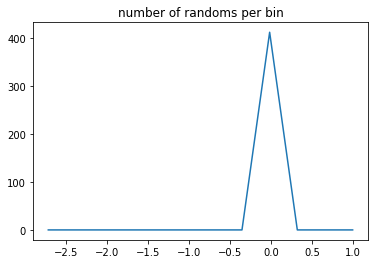

In [47]:
# now for randoms:

import matplotlib.pyplot as plt

#print(random_val.dtype.names)

# convert RA and DEC to PIXELS for randoms:
phi = random_val['RA'] * np.pi / 180.0
theta = ( 90.0 - random_val['DEC'] ) * np.pi/180.0
nside= 512
random_pix = hp.ang2pix(nside,theta,phi,nest=True)
#print(random_pix)

index_ran_mask = np.argsort(random_pix)
random_chron = random_pix[index_ran_mask] # ordered by hpix values

dim_ran_mask = np.in1d(sysMap['PIXEL'], random_chron, assume_unique=False, invert=False)

minimum = np.percentile(sysMap['SIGNAL'][dim_mask], 1)
#minimum = np.percentile(sysMap['SIGNAL'], 1)
#minimum = np.min(sysMap['SIGNAL'][dim_mask]) #FWHM signal (for g filter)
maximum = np.percentile(sysMap['SIGNAL'][dim_mask], 99)
#maximum = np.percentile(sysMap['SIGNAL'], 99)
#print(minimum)
#print(maximum)

pbin = np.linspace(minimum, maximum, 13)
pcenter = pbin[:-1] + 0.025

x = np.zeros(hp.nside2npix(512))
x[sysMap['PIXEL'][dim_ran_mask]] = sysMap['SIGNAL'][dim_ran_mask]
#x[sysMap['PIXEL']] = sysMap['SIGNAL']

#systematic value at galaxy location:

sysval_ran_gal = x[random_chron]
#print(sysval_ran_gal)
h_ran,_ = np.histogram(sysval_ran_gal , bins=pbin)
#print(h_ran)

# want this plotted:
#h/number_of_pixels_in_sysbin

#fracerr = 1/np.sqrt(h_ran) #1 / sqrt(number of cmass galaxies in each bin)

# change to number density: divide by area
fig, ax = plt.subplots()
ax.errorbar( pcenter, h_ran)
#ax.legend(chi2_reduced)
plt.title('number of randoms per bin')
fig.savefig('random_bin.pdf')

sys_ran_signal = sysMap['SIGNAL'][dim_ran_mask]
#sys_ran_signal = sysMap['SIGNAL']
n_ran,_ = np.histogram(sys_ran_signal , bins=pbin )
print('without weights:')
print(n_ran)

matched_ran_sys = sysMap[dim_ran_mask]
#matched_ran_sys = sysMap
mask = np.zeros(hp.nside2npix(512))
bao_mask_ran = np.in1d(LSSGoldmask["PIXEL"], matched_ran_sys["PIXEL"], assume_unique=False, invert=False)
mask[matched_ran_sys["PIXEL"]] = matched_ran_sys["SIGNAL"]

BAO_sys_ran = mask[LSSGoldmask["PIXEL"][bao_mask_ran]]

area1_ran,_ = np.histogram(BAO_sys_ran , bins=pbin , weights = LSSGoldmask["SIGNAL"][bao_mask_ran])
print('with weights:')
print(area1_ran)

matched_ran_sys2 = sysMap[dim_ran_mask]
#matched_ran_sys2 = sysMap
mask2 = np.zeros(hp.nside2npix(512))
bao_mask2_ran = np.in1d(fracDet["PIXEL"], matched_ran_sys["PIXEL"], assume_unique=False, invert=False)
mask2[matched_ran_sys["PIXEL"]] = matched_ran_sys["SIGNAL"]
frac_sys_ran = mask2[fracDet["PIXEL"][bao_mask2_ran]]

area_ran,_ = np.histogram(frac_sys_ran , bins=pbin , weights = fracDet["SIGNAL"][bao_mask2_ran])
print('area with weights:')
print(area_ran)

# h = number of galaxies
print("number of random galaxies: ", h_ran)

# number density in bins: h/area
number_density_ran = []
for x in range(len(h)):
    den_ran = h_ran[x]/area_ran[x]
    number_density_ran.append(den_ran)
    
print("randoms number density: ", number_density_ran)


total_area_ran = 0
#Normalize based on total number density of used footprint:
for x in range(len(area_ran)):
    total_area_ran += area_ran[x]

print("total_area: ", total_area_ran)

# total galaxies:
total_h_ran = 0
for x in range(len(h_ran)):
    total_h_ran += h_ran[x]

print("total galaxies: ", total_h_ran)

#normalization: 
total_num_density_ran = total_h_ran/total_area_ran

print("total number density: ", total_num_density_ran)

# apply normalization: 
#print(number_density)
norm_number_density_ran = number_density_ran/total_num_density_ran
print(norm_number_density_ran)

fracerr_ran = np.sqrt(h_ran) #1 / sqrt(number of randoms cmass galaxies in each bin)
fracerr_ran_norm = (fracerr_ran/area_ran)/total_num_density_ran
print("normalized error: ", fracerr_ran_norm)

In [48]:
print(h_ran)
print(area_ran)


[  0   0   0   0   0   0   0   0 412   0   0   0]
[  0.        0.        0.        0.        0.        0.        0.
   0.      267.84375   0.        0.        0.     ]


Text(0.5, 1.0, 'number of randoms versus dmass per bin')

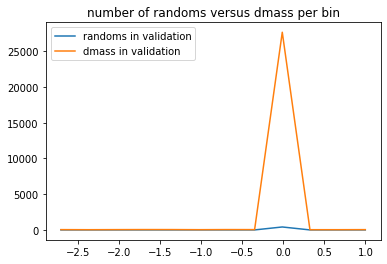

In [49]:
fig, ax = plt.subplots()
ax.errorbar( pcenter, h_ran, label = "randoms in validation")
ax.errorbar( pcenter, h, label = "dmass in validation")
plt.legend()
#ax.legend(chi2_reduced)
plt.title('number of randoms versus dmass per bin')

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3323: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


dmass number density:  [inf, inf, inf, inf, inf, inf, inf, inf, 26.183055991847663, inf, inf, inf]
total_area:  1056.75
total galaxies:  28097.955181179925
normalized error:  [    inf     inf     inf     inf     inf     inf     inf     inf 0.00592
     inf     inf     inf]
total number density:  26.58902785065524
[      inf       inf       inf       inf       inf       inf       inf
       inf 0.9847316       inf       inf       inf]


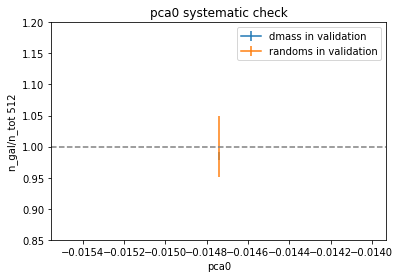

In [50]:
# *****Creating the figure******:

#Also, we usually normalize the plots to the total number density of the total footprint considered. 
#so that we expect the final result to be a flat line at y=1.

# number density in bins: h/area
number_density = []
for x in range(len(h)):
    den = h[x]/area[x]
    number_density.append(den)
    
print("dmass number density: ", number_density)

total_area = 0
#Normalize based on total number density of used footprint:
for x in range(len(area)):
    total_area += area[x]

print("total_area: ", total_area)

# total galaxies:
total_h = 0
for x in range(len(h)):
    total_h += h[x]

print("total galaxies: ", total_h)

#normalization: 
total_num_density = total_h/total_area


#errorbars: (how to define these)
fracerr = np.sqrt(h)
fracerr_norm = (fracerr/area)/total_num_density
print("normalized error: ", fracerr_norm)


print("total number density: ", total_num_density)

# apply normalization: 
#print(number_density)
norm_number_density = number_density/total_num_density
print(norm_number_density)

import matplotlib.pyplot as plt
#figure of systematics:

fracerr = 1/np.sqrt(h) #1 / sqrt(number of cmass galaxies in each bin)

# change to number density: divide by area
fig, ax = plt.subplots()
ax.errorbar( pcenter, norm_number_density, yerr=fracerr_norm, label = "dmass in validation")
ax.errorbar( pcenter, norm_number_density_ran, yerr=fracerr_ran_norm, label = "randoms in validation")
plt.legend()
plt.xlabel("pca0")
plt.ylabel("n_gal/n_tot 512")
plt.ylim(top=1.2)  # adjust the top leaving bottom unchanged
plt.ylim(bottom=0.85)
plt.axhline(y=1, color='grey', linestyle='--')
plt.title('pca0 systematic check')
fig.savefig('pca0.pdf')

In [60]:
#check: fracdet working properly
#chi_2/degree of freedom (= number of bins) check to be close to 1 for normalized number density

x1=norm_number_density
x2=np.ones_like(x1)
err=fracerr_norm
chi2 = (x1-x2)**2 / err **2 
chi2_reduced = sum(chi2)/chi2.size #chi_2/degree of freedom
print("chi2_reduced: ",chi2_reduced)
print("size: ",chi2.size)
print("sum of chi2: ",sum(chi2))

x1=norm_number_density_ran
x2=np.ones_like(x1)
err=fracerr_ran_norm
chi2_ran = (x1-x2)**2 / err **2 
chi2_reduced_ran = sum(chi2_ran)/chi2_ran.size
print("chi2_reduced for randoms: ",chi2_reduced_ran) #chi_2/degree of freedom
print("size: ",chi2_ran.size)
print("sum of chi2 for randoms: ",sum(chi2_ran))

#####if this doesnt work: reduce resolution to 512 for both (and systematic maps)

chi2_reduced:  3.231221226017024
size:  12
sum of chi2:  38.77465471220429
chi2_reduced for randoms:  0.0189370896171463
size:  12
sum of chi2 for randoms:  0.22724507540575561


In [ ]:
# Before presenting new plots:

# Build description of plots to present results-- are these good results?
# Are these showing the right things
# Statistical power of new data (improved) can cause problems where there wasn't before in Y1
# Think about the science of the plots -- is there more we can get from them

# equation to test if data difference is noise or significant -- chi_2, difference(including noise), linear fit to trend (numpy) -- error on slope

# Interesting investigations into what data is saying

# Put plots in slides with Su's Y1 comparison
# look at Su's code in detail: verification 

# Parallel processing with research-- the science direction of coding, different problems to look into

In [ ]:
# add limits to narrow range of x axis
# use first and last percentile for limits instead of min max of x-axis
# np.percentile() -- for less noisy plot ** 2nd and 99th


#location of systematic maps:
#/global/cfs/cdirs/des/jelvinpo/sysmaps/y3/

In [40]:
# don't run: check

#dim_mask = np.in1d(sysMap['PIXEL'], dmass_chron['HPIX_4096'], assume_unique=False, invert=False)

print(sysMap['PIXEL'][dim_mask])
print(dmass_chron['HPIX_4096'])

[    35370     35456     35458 ... 150977211 150977212 150977214]
[35370 35370 35456 ... 150977212 150977212 150977214]


In [11]:
# not this one

minimum = np.min(sysMap['PIXEL'])
maximum = np.max(sysMap['PIXEL'])
print(sysMap['SIGNAL'])
#np.min(sysMap['PIXEL'])
#np.max(sysMap['PIXEL'])
minpix = np.min(dmass_val['HPIX_4096'])
maxpix = np.max(dmass_val['HPIX_4096'])
#pbin = np.linspace(minimum, maximum, 13)
print(minpix)
print(maxpix)
#M, _ = np.histogram(dmass_val, bins=pbin) #shaded gray in plot

#number density of each
sysMaps_len = sysMap['PIXEL'].size
dmass_len = dmass_val['HPIX_4096'].size
print(dmass_len)

[1.0857818 1.0857818 1.0857818 ... 1.0808538 1.0808538 1.0808538]
35370
150977214
2741190


In [12]:
#unnecessay

#compare two arrays: mask first array
# sort dmass value to be chronilogical order:
index_mask = np.argsort(dmass_val['HPIX_4096'])

#print(index_mask)
#hpix_smallest = dmass_val['HPIX_4096'][2111516]

dmass_chron = dmass_val[index_mask] # ordered by hpix values

dim_mask = np.in1d(sysMap['PIXEL'], dmass_chron['HPIX_4096'], assume_unique=False, invert=False)
                    
#print(dim_mask)
#sys_pix = sysMap['PIXEL'][dim_mask]
#print(sys_pix)

In [12]:
print(dmass_chron['HPIX_4096'])

[35370 35370 35456 ... 150977212 150977212 150977214]


In [ ]:
# don't use this one

dmass_signal = []

for x in range(sysMaps_len):
    if sysMap['PIXEL'][x] > minpix or sysMap['PIXEL'][x] == minpix:
        if sysMap['PIXEL'][x] < maxpix or sysMap['PIXEL'][x] == maxpix:
            for y in range(dmass_len):
                if dmass_val['HPIX_4096'][y] == sysMap['PIXEL'][x]:
                    dmass_signal.append(sysMap['SIGNAL'][x])
                    
print(dmass_signal)

In [ ]:
# don't run this
# save the corresponding dmass signal
outdir = '../output/test/train_cat/y3/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'dmass_signal.fits', dmass_signal, overwrite=True)

In [ ]:
# notes
# number of galaxies in each pixel:

# dmass catalog turned into healpix map
# counting number of galaxies in each healpix pixel -- some numpy?
# dividing healpix pixel area --- corresponding area to 4096 resolution -- to get number density (plus mask -- later) FRACDET

# 1) galaxy number counts and area for each healpix pixel -- match healpix with area map?

dmass_counts = []
dmass_healpix = []
value_last = 0
arr = dmass_chron['HPIX_4096']

#check:
count = arr[arr==dmass_chron['HPIX_4096'][0]].shape[0]
print(count)

breakpoint()
#collections counter -- 
for x in range(len(dmass_chron['HPIX_4096'])):
    value = dmass_chron['HPIX_4096'][x]
    if value != value_last:
        count = arr[arr==value].shape[0]
    dmass_counts.append(count)
    dmass_healpix.append(value)

print(dmass_counts)
print(dmass_healpix)

2
--Return--
None
> <ipython-input-13-6303d079ef40>(18)<module>()
     16 print(count)
     17 
---> 18 breakpoint()
     19 #collections counter --
     20 for x in range(len(dmass_chron['HPIX_4096'])):



ipdb>  l


     13 
     14 #check:
     15 count = arr[arr==dmass_chron['HPIX_4096'][0]].shape[0]
     16 print(count)
     17 
---> 18 breakpoint()
     19 #collections counter --
     20 for x in range(len(dmass_chron['HPIX_4096'])):
     21     value = dmass_chron['HPIX_4096'][x]
     22     if value != value_last:
     23         count = arr[arr==value].shape[0]



ipdb>  n


    [... skipped 1 hidden frame]

> /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3346)run_code()
   3344             finally:
   3345                 # Reset our crash handler in place
-> 3346                 sys.excepthook = old_excepthook
   3347         except SystemExit as e:
   3348             if result is not None:



ipdb>  c


In [ ]:
# not run
# save the dmass counts and healpix arrays
outdir = '../output/test/train_cat/y3/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'dmass_counts.fits', dmass_counts, overwrite=True)

outdir = '../output/test/train_cat/y3/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'dmass_healpix.fits', dmass_healpix, overwrite=True)

In [13]:
# 2) match healpix map with systematic maps (using same method as above)

dim_mask = np.in1d(sysMap['PIXEL'], dmass_healpix, assume_unique=False, invert=False)
                    
#print(dim_mask)
sys_pix = sysMap['PIXEL'][dim_mask]
print(sys_pix)

NameError: name 'dmass_healpix' is not defined

In [ ]:
# 3) array with: healpix pixel value, galaxy counts, area --- binned in signal histogram
# for all signal bins : total number counts in healpix pixels / totsl area of healpix pixels used in same bin --- number density
import matplotlib.pyplot as plt

# area: 6.24178e-08 square degrees ---- from github (without masking bad regions)

minimum = np.min(sysMap['SIGNAL'][dim_mask]) #FWHM signal (for g filter)
maximum = np.max(sysMap['SIGNAL'][dim_mask])

print(minimum)
print(maximum)

pbin = np.linspace(minimum, maximum, 13)
pcenter = pbin[:-1] + 0.025

#another option: step through min max of pbin, bolean of pixel falls within, take average

N, _ = np.histogram(dmass_counts, bins=pbin)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of cmass galaxies in each bin)

# change to number density: divide by area
fig, ax = plt.subplots()
ax.errorbar( pcenter, number_density, yerr=fracerr)
#ax.legend(chi2_reduced)
plt.title('Systematic Test')
fig.savefig('SystematicTest1.pdf')

# do the same with randoms
print(random_val.dtype.names)

In [ ]:
# take all objects in each bin of systematic value

In [ ]:
#rsync systematics:
# rsync -r warner785@pitzer.osc.edu:/fs/scratch/PCON0003/warner785/bwarner/ .